# Web Traffic Analysis
This covers the web traffic analysis of the iNethi network at three vantage points (mesh, school, servers)

In [211]:
import pandas as pd
import numpy as np
import gc
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import calendar
from scipy.stats import describe
from scipy import stats
from user_agents import parse

import seaborn as sns
#sns.set(style="ticks", palette="pastel")

plt.style.use('default')

inethi = {'admin.inethi.net': '10.2.3.1',
          'api.inethi.net': '10.2.0.20',
          'box.inethi.net': '10.2.0.12',
          'chat.inethi.net': '10.2.1.11',
          'diaspora.inethi.net': '10.2.1.15',
          'home.inethi.net': '10.2.0.10',
          'inethibox.inethi.net': '10.2.0.12',
          'ldap.inethi.net': '10.2.0.10',
          'login.inethi.net': '10.10.0.2',
          'mongo.inethi.net': '10.2.1.11',
          'mysql.inethi.net': '10.2.1.14',
          'owncloud.inethi.net': '10.2.1.13',
          'radiusdesk.inethi.net': '10.2.0.3',
          'radiusv2.inethi.net': '10.2.1.18',
          'splash.inethi.net': '10.2.1.17'
         }
df_inethi = pd.DataFrame.from_dict(inethi, orient='index')
df_inethi.reset_index(inplace=True)
df_inethi.columns=['host','ip_src']

def hitCount(df, fieldname):
    df = df.groupby(['date']).count()[['ip_src']]
    df.index = pd.to_datetime(df.index, dayfirst=False,  errors='coerce')
    df.columns=[fieldname]
    df = df.resample('D').sum()
    df = df.reset_index()
    return df

def sumTraffic(df, fieldname):
    df.set_index(df.date, drop=True, inplace=True)
    df= df.drop(columns=['date'])
    df = df.resample('D').sum()
    df.columns=[fieldname]
    df = df.replace([np.inf, -np.inf], np.nan)
    #df = df[[fieldname]].div(1e+9, axis=0)
    df = df.reset_index()
    df = df.dropna()
    return df

def extractLocalTraffic(df):
    df_local = df.loc[df.ip_src.str.startswith('10.2', na=False)]
    df_local = df_local.loc[df_local.ip_dst.str.startswith('10.', na=False)]
    return df_local

def extractGlobalTraffic(df):
    df_global = df.loc[~(df.ip_src.str.startswith('10.', na=False))]
    df_global = df_global.loc[df_global.ip_dst.str.startswith('10.', na=False)]
    return df_global

def extractUserTraffic(df, ips, startDate, endDate):
    ipmask = ""
    iparray = ips.split(";")
    count=0
    for ip in iparray:
        if ip:
            ipmask = ipmask + "(df.ip_dst_x=='" + ip +"')"
            count = count + 1
            if (count < len(iparray)-1):
                ipmask = ipmask + "|"
    
    mask = ((df['date'] > startDate) & (df['date'] < endDate) & (eval(ipmask)))
    df =  df.loc[mask].groupby(['host_y']).sum()[['frame_len']]
    df.reset_index(inplace=True)
    df['short_host'] = df.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
    return df.groupby(['short_host']).sum()[['frame_len']].sort_values(['frame_len'], ascending=False)
    #return df.groupby(['host_y']).sum()[['frame_len']].sort_values(['frame_len'], ascending=False)


In [12]:
df_mesh = pd.read_csv('/Volumes/My Passport/inethi/data/http/mesh.csv', 
                      sep='|', 
                      error_bad_lines=False, 
                      warn_bad_lines=False,
                      #names=['time_epoch','ip_src','srcport','ip_dst','dstport','request_version','request_method','host','request_uri','user_agent','response_code','content_type','content_length','location','referer','request_full_uri','frame_len','tcp_len', 'ip_len', 'http_time'],
                      dtype={'frame_len': 'int64'}
                     )
df_mesh['date']=pd.to_datetime(df_mesh.time_epoch, unit='s')

/Users/amreesh/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,12,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_school = pd.read_csv('/Volumes/My Passport/inethi/data/http/school.csv', 
                      sep='|', 
                      error_bad_lines=False, 
                      warn_bad_lines=False,
                      dtype={'frame_len': 'int64'}
                     )
df_school['date']=pd.to_datetime(df_school.time_epoch, unit='s')

/Users/amreesh/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,12,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df_servers = pd.read_csv('/Volumes/My Passport/inethi/data/http/servers.csv', 
                      sep='|', 
                      error_bad_lines=False, 
                      warn_bad_lines=False,
                      dtype={'frame_len': 'int64'}
                     )
df_servers['date']=pd.to_datetime(df_servers.time_epoch, unit='s')

/Users/amreesh/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10,12,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## User-agents
Study the different types of user-agents and extract the phone and browser used

In [6]:
df_uas = pd.DataFrame(columns=['ua', 'brand', 'os', 'browser', 'mobile', 'tablet', 'pc', 'bot','touch'])

ua_mesh_array = np.array(df_mesh.user_agent.unique())
ua_school_array = np.array(df_school.user_agent.unique())
ua_servers_array = np.array(df_servers.user_agent.unique())

ua_array = np.concatenate((ua_mesh_array, ua_school_array, ua_servers_array), axis=0)

ua_array = ua_array[~pd.isnull(ua_array)]

for ua_string in ua_array:
    user_agent = parse(ua_string)
    summary = str(user_agent)
    df_uas = df_uas.append({'ua' : ua_string, 
                           'brand': summary.split('/')[0] , 
                           'os': summary.split('/')[1] , 
                           'browser': summary.split('/')[2], 
                           'mobile': user_agent.is_mobile, 
                           'tablet': user_agent.is_tablet , 
                           'pc': user_agent.is_pc, 
                           'bot': user_agent.is_bot,
                           'touch': user_agent.is_touch_capable}, ignore_index=True)
df_uas.head()

,ua,brand,os,browser,mobile,tablet,pc,bot,touch
0,Avast NCC,Other,Other,Other,False,False,False,False,False
1,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,PC,Linux,Chrome 60.0.3112,False,False,True,False,False
2,Dalvik/1.6.0 (Linux; U; Android 4.3; GT-I9500 ...,Samsung GT-I9500,Android 4.3,Android 4.3,False,True,False,False,True
3,Dalvik/2.1.0 (Linux; U; Android 8.1.0; ASTRO B...,ASTRO,Android 8.1.0,Android 8.1.0,False,True,False,False,True
4,Dalvik/2.1.0 (Linux; U; Android 7.0; S61 JAZZ ...,S61 JAZZ,Android 7.0,Android 7.0,False,True,False,False,True


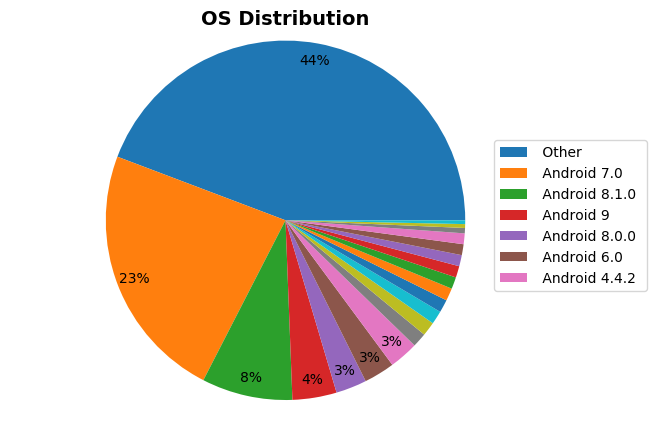

In [22]:
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > 2 else ''

df_pie = df_uas.groupby(['os']).count()[['ua']].sort_values('ua', ascending=False)[:20]
#ax = df_pie.plot(x='os', y='ua', kind='pie', label='OS', figsize=(4, 4))
df_pie = df_pie.reset_index()
# plt.legend(loc='best')
# plt.savefig('plots/pie_os_distribution.pdf')
# plt.show()
plt.gca().axis("equal")
pie = plt.pie(df_pie.ua, startangle=0, autopct=my_autopct, pctdistance=0.9, radius=1.2)
labels=df_pie.os.unique()
plt.title('OS Distribution', weight='bold', size=14)
plt.legend(pie[0],labels[:7], bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.0, bottom=0.1, right=0.85)

plt.show()
plt.clf()
plt.close()

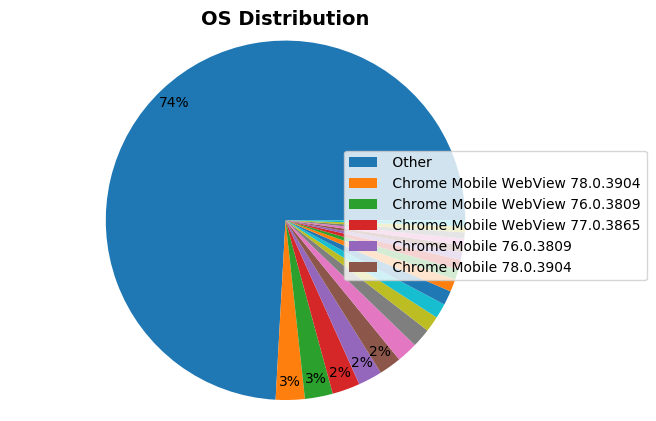

In [29]:
#df_browser = df_uas.loc[~df_uas.browser.str.startswith(' Android')]



def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > 2 else ''

df_pie = df_browser.groupby(['browser']).count()[['ua']].sort_values('ua', ascending=False)[:20]
df_pie = df_pie.reset_index()
plt.gca().axis("equal")
pie = plt.pie(df_pie.ua, startangle=0, autopct=my_autopct, pctdistance=0.9, radius=1.2)
labels=df_pie.browser.unique()
plt.title('OS Distribution', weight='bold', size=14)
plt.legend(pie[0],labels[:6], bbox_to_anchor=(1,0.5), loc="center right", fontsize=10, 
           bbox_transform=plt.gcf().transFigure)
plt.subplots_adjust(left=0.0, bottom=0.1, right=0.85)

plt.show()
plt.clf()
plt.close()

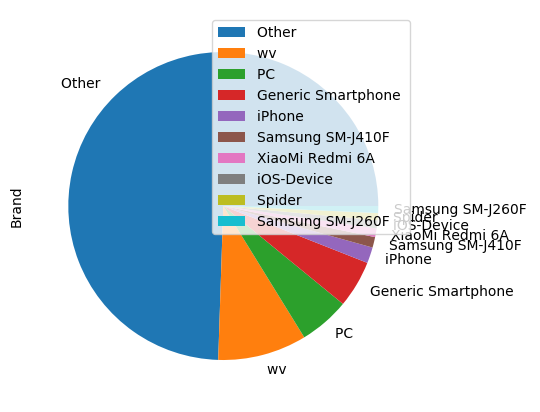

In [30]:
df_browser.groupby(['brand']).count()[['ua']].sort_values('ua', ascending=False)[:10].plot(x='brand', y='ua', kind='pie', figsize=(5, 5), label='Brand')

### Hits on local vs global services

In [13]:
df_local_mesh = extractLocalTraffic(df_mesh)
df_global_mesh = extractGlobalTraffic(df_mesh)

In [14]:
df_local_mesh_sum = sumTraffic(df_local_mesh.iloc[:,[20,16]], 'traffic')
df_global_mesh_sum = sumTraffic(df_global_mesh.iloc[:,[20,16]], 'traffic')

In [6]:
df_local_school = extractLocalTraffic(df_school)
df_global_school = extractGlobalTraffic(df_school)

In [7]:
df_local_school_sum = sumTraffic(df_local_school.iloc[:,[20,16]], 'traffic')
df_global_school_sum = sumTraffic(df_global_school.iloc[:,[20,16]], 'traffic')

In [24]:
df_local_servers = extractLocalTraffic(df_servers)
df_global_servers = extractGlobalTraffic(df_servers)

In [25]:
df_local_servers_sum = sumTraffic(df_local_servers.iloc[:,[20,16]], 'traffic')
df_global_servers_sum = sumTraffic(df_global_servers.iloc[:,[20,16]], 'traffic')

In [15]:
df_hosts = [df_mesh.iloc[:,[3,7]], df_school.iloc[:,[3,7]]]
df_hosts = pd.concat(df_hosts, sort=True)
df_hosts = df_hosts.dropna().drop_duplicates()
df_hosts = df_hosts.loc[~df_hosts.host.str.contains(':')]

In [38]:
del df_mesh
del df_browser
del df_pie
del df_uas
del df_school
del df_servers
gc.collect()

13332

#### Mesh Local vs External traffic

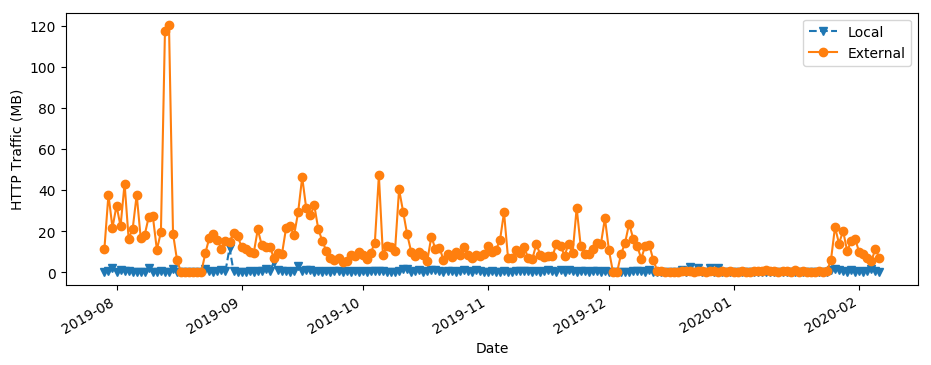

In [165]:
fig, ax = plt.subplots(figsize=(11, 4))

# df_local_mesh.plot(ax, x="date", y=["mesh"], kind="line", marker='.', linestyle='-', )
# df_local_school.plot(ax, x="date", y=["school"], kind="line", marker='.', linestyle='-')
# df_local_servers.plot(ax, x="date", y=["servers"], kind="line", marker='.', linestyle='-')

ax.plot(df_local_mesh_sum.date, df_local_mesh_sum.traffic/1e+6, marker='v', linestyle='--', label='Local')
ax.plot(df_global_mesh_sum.date, df_global_mesh_sum.traffic/1e+6, marker='o', linestyle='-', label='External')

ax.set_ylabel('HTTP Traffic (MB)')
ax.set_xlabel('Date')
#ax.set_yscale('symlog')
fig.autofmt_xdate()

ax.legend()

plt.savefig('plots/http_daily_traffic_mesh.pdf')
plt.show()

In [151]:
df_global_school_sum = df_global_school_sum.dropna().drop([177,181,179])

In [152]:
#df_local_school_sum = df_local_school_sum.dropna()

#### School Local vs External traffic

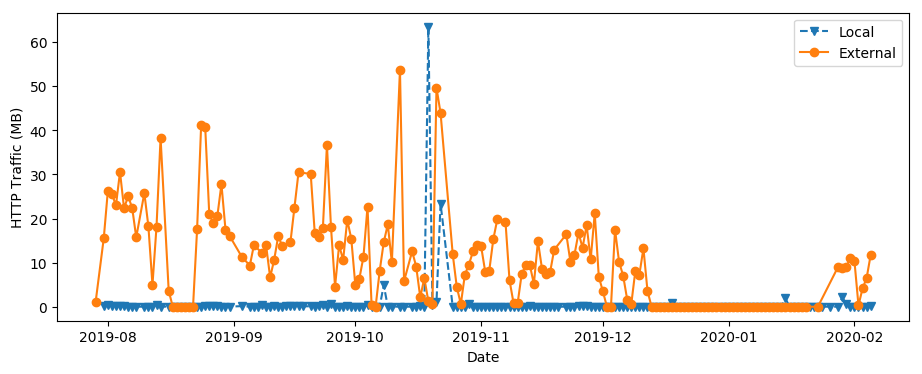

In [166]:
fig, ax = plt.subplots(figsize=(11, 4))

ax.plot(df_local_school_sum.date, df_local_school_sum.traffic/1e+6, marker='v', linestyle='--', label='Local')
ax.plot(df_global_school_sum.date, df_global_school_sum.traffic/1e+6, marker='o', linestyle='-', label='External')

ax.set_ylabel('HTTP Traffic (MB)')
ax.set_xlabel('Date')
#ax.set_yscale('log')
#fig.autofmt_xdate()

ax.legend()

plt.savefig('plots/http_daily_traffic_school.pdf')
plt.show()

#### Servers Local vs External

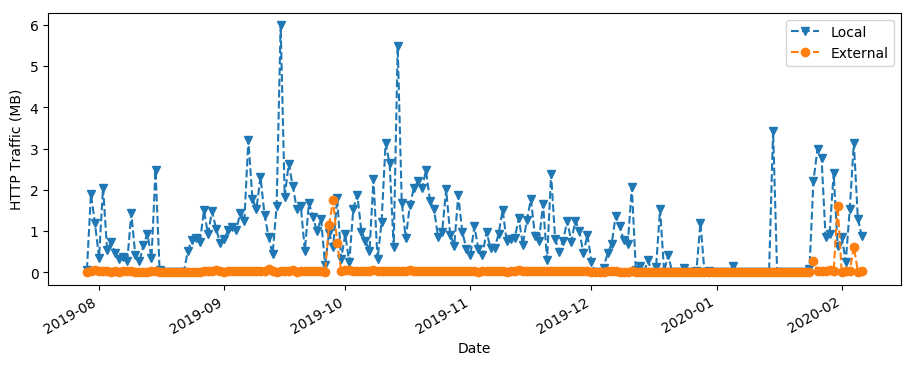

In [167]:
fig, ax = plt.subplots(figsize=(11, 4))

ax.plot(df_local_servers_sum.date, df_local_servers_sum.traffic/1e+6, marker='v', linestyle='--', label='Local')
ax.plot(df_global_servers_sum.date, df_global_servers_sum.traffic/1e+6, marker='o', linestyle='--', label='External')

ax.set_ylabel('HTTP Traffic (MB)')
ax.set_xlabel('Date')
#ax.set_yscale('log')
fig.autofmt_xdate()

ax.legend()

plt.savefig('plots/http_daily_traffic_servers.pdf')
plt.show()

### Most visited websites (External)
#### Mesh

In [39]:
df_hosts.head()

,host,ip_dst
0,cdn.samsungcloudsolution.com,143.204.65.189
44,ncc.avast.com,105.225.1.226
70,cdn.samsungcloudsolution.com,143.204.65.208
93,connectivitycheck.gstatic.com,216.58.223.131
121,play.googleapis.com,172.217.170.74


In [45]:
df_global_mesh = df_global_mesh.merge(df_hosts, how='left', left_on='ip_src', right_on='ip_dst')

In [41]:
#df_global_mesh['short_host'] = df_global_mesh.apply(lambda x: '.'.join(x.host.split('.')[-2:]), axis=1)
df_mv_hosts = df_global_mesh.groupby(['host_y']).sum()[['frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts = df_mv_hosts.reset_index()
df_mv_hosts['frame_len'] = df_mv_hosts.frame_len/1e+6

df_mv_hosts['short_host'] = df_mv_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mv_hosts = df_mv_hosts.groupby(['short_host']).sum()[['frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts = df_mv_hosts.reset_index()

df_mh_hosts = df_global_mesh.groupby(['host_y']).count()[['ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)
df_mh_hosts = df_mh_hosts.reset_index()
df_mh_hosts['short_host'] = df_mh_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mh_hosts = df_mh_hosts.groupby(['short_host']).sum()[['ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)
df_mh_hosts = df_mh_hosts.reset_index()

In [42]:
df_mhv_hosts = df_mv_hosts.merge(df_mh_hosts, how='outer', on='short_host',)

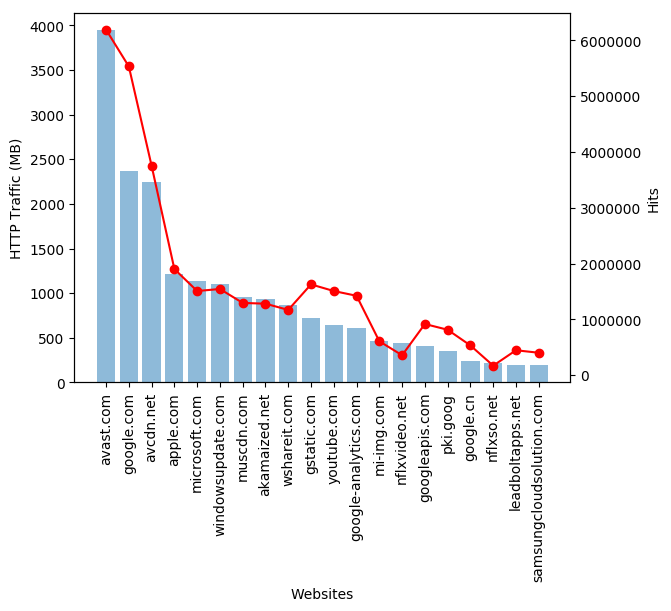

In [43]:
fig, ax1 = plt.subplots()

df_list = df_mhv_hosts[:20]

ax1.bar(df_list.short_host, df_list.frame_len, alpha=0.5)
ax1.set_ylabel('HTTP Traffic (MB)')
ax1.set_xlabel('Websites')

ax2 = ax1.twinx()
ax2.plot(df_list.short_host, df_list.ip_src, marker="o", color='r')
ax2.set_ylabel('Hits')

for ax in (ax1, ax2):
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig('plots/http_traffic_mesh_merged.pdf')
plt.show()

#### School

In [16]:
df_global_school = df_global_school.merge(df_hosts, how='left', left_on='ip_src', right_on='ip_dst')
df_mv_hosts = df_global_school.groupby(['host_y'], as_index=False).sum()[['host_y','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['short_host'] = df_mv_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mv_hosts = df_mv_hosts.groupby(['short_host'], as_index=False).sum()[['short_host','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['frame_len'] = df_mv_hosts.frame_len/1e+6

df_mh_hosts = df_global_school.groupby(['host_y'], as_index=False).count()[['host_y','ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)
df_mh_hosts['short_host'] = df_mh_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mh_hosts = df_mh_hosts.groupby(['short_host'], as_index=False).sum()[['short_host','ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)

In [17]:
df_mhv_hosts = df_mv_hosts.merge(df_mh_hosts, how='outer', on='short_host')

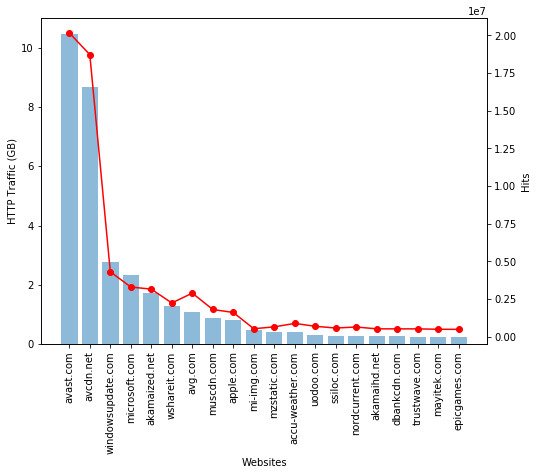

In [22]:
fig, ax1 = plt.subplots(figsize=(8,6))

df_list = df_mhv_hosts[:20]

ax1.bar(df_list.short_host, df_list.frame_len/1024, alpha=0.5)
ax1.set_ylabel('HTTP Traffic (GB)')
ax1.set_xlabel('Websites')

ax2 = ax1.twinx()
ax2.plot(df_list.short_host, df_list.ip_src, marker="o", color='r')
ax2.set_ylabel('Hits')

for ax in (ax1, ax2):
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig('plots/http_traffic_school_merged.pdf')
plt.show()

#### Servers

In [26]:
df_global_servers = df_global_servers.merge(df_hosts, how='left', left_on='ip_src', right_on='ip_dst')
df_mv_hosts = df_global_servers.groupby(['host_y'], as_index=False).sum()[['host_y','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['short_host'] = df_mv_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mv_hosts = df_mv_hosts.groupby(['short_host'], as_index=False).sum()[['short_host','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['frame_len'] = df_mv_hosts.frame_len/1e+6

df_mh_hosts = df_global_servers.groupby(['host_y'], as_index=False).count()[['host_y','ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)
df_mh_hosts['short_host'] = df_mh_hosts.apply(lambda x: '.'.join(x.host_y.split('.')[-2:]), axis=1)
df_mh_hosts = df_mh_hosts.groupby(['short_host'], as_index=False).sum()[['short_host','ip_src']]
df_mh_hosts.sort_values(['ip_src'], ascending=False, inplace=True)

In [27]:
df_mhv_hosts = df_mv_hosts.merge(df_mh_hosts, how='outer', on='short_host')

In [28]:
df_mhv_hosts.sort_values(by=['frame_len'], ascending=False, inplace=True)
df_mhv_hosts.head()

,short_host,frame_len,ip_src
0,ubuntu.com,10.357809,16610
1,teamviewer.com,5.909099,29445
2,google.com,1.565761,4112
3,youtube.com,0.438770,1166
4,google-analytics.com,0.425032,1088


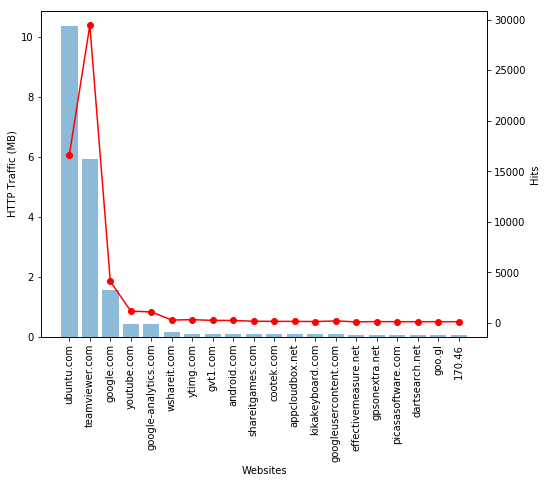

In [30]:
fig, ax1 = plt.subplots(figsize=(8,6))

df_list = df_mhv_hosts[:20]

ax1.bar(df_list.short_host, df_list.frame_len, alpha=0.5)
ax1.set_ylabel('HTTP Traffic (MB)')
ax1.set_xlabel('Websites')

ax2 = ax1.twinx()
ax2.plot(df_list.short_host, df_list.ip_src, marker="o", color='r')
ax2.set_ylabel('Hits')

for ax in (ax1, ax2):
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig('plots/http_traffic_servers_merged.pdf')
plt.show()

### Most visited websites (Internal)

In [78]:
df_mv_hosts = df_local_mesh.groupby(['ip_src'], as_index=False).sum()[['ip_src','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['frame_len'] = df_mv_hosts.frame_len/1e+6

df_mh_hosts = df_local_mesh.groupby(['ip_src'], as_index=False).count()[['ip_src','date']]
df_mh_hosts.sort_values(['date'], ascending=False, inplace=True)

In [79]:
df_mhv_hosts = df_mv_hosts.merge(df_mh_hosts, how='outer', on='ip_src')

#### From the Mesh

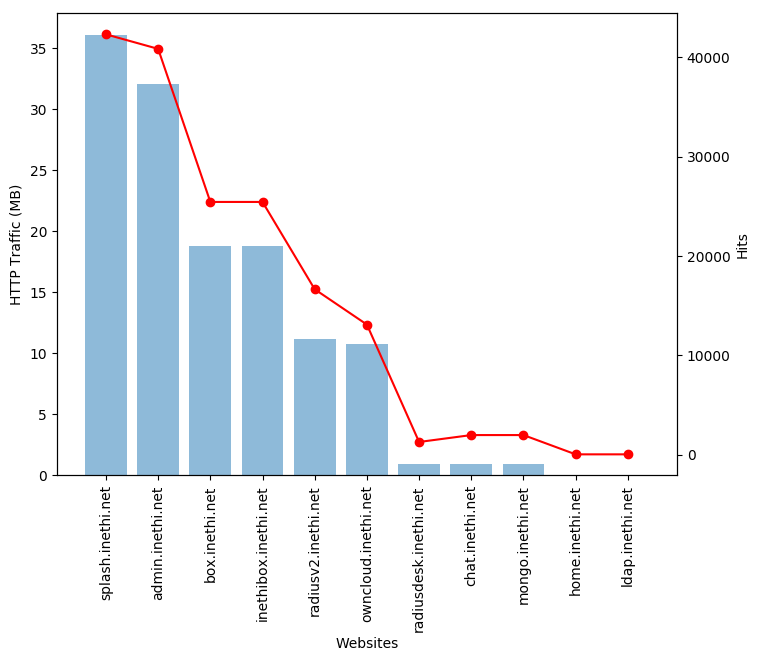

In [82]:
fig, ax1 = plt.subplots(figsize=(8,6))

df_list = df_mhv_hosts[:20]
df_list = df_list.merge(df_inethi, on='ip_src')

ax1.bar(df_list.host, df_list.frame_len, alpha=0.5)
ax1.set_ylabel('HTTP Traffic (MB)')
ax1.set_xlabel('Websites')

ax2 = ax1.twinx()
ax2.plot(df_list.host, df_list.date, marker="o", color='r')
ax2.set_ylabel('Hits')

for ax in (ax1, ax2):
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig('plots/http_traffic_internal_mesh.pdf')
plt.show()

In [40]:
df_mv_hosts = df_local_school.groupby(['ip_src'], as_index=False).sum()[['ip_src','frame_len']]
df_mv_hosts.sort_values(['frame_len'], ascending=False, inplace=True)
df_mv_hosts['frame_len'] = df_mv_hosts.frame_len/1e+6

df_mh_hosts = df_local_school.groupby(['ip_src'], as_index=False).count()[['ip_src','date']]
df_mh_hosts.sort_values(['date'], ascending=False, inplace=True)
df_mhv_hosts = df_mv_hosts.merge(df_mh_hosts, how='outer', on='ip_src')

#### From the School

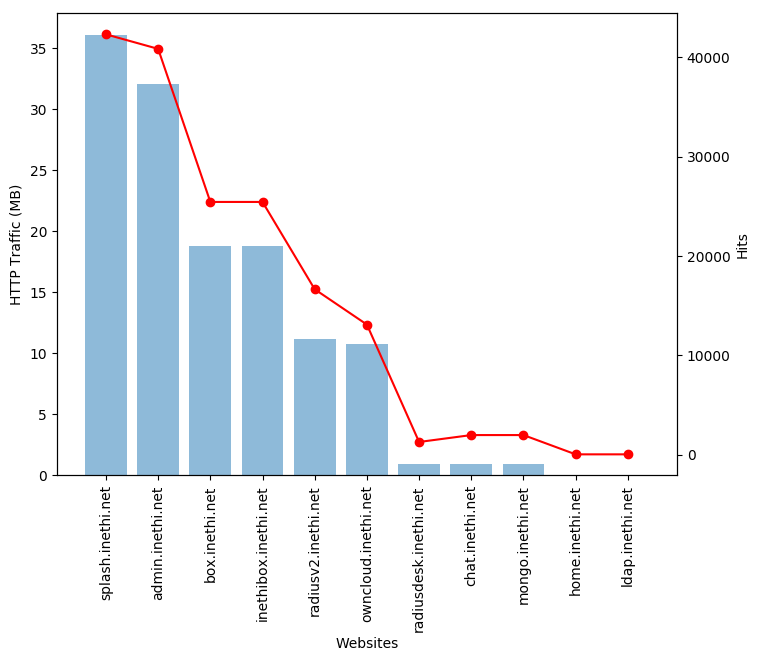

In [77]:
fig, ax1 = plt.subplots(figsize=(8,6))

df_list = df_mhv_hosts[:20]
df_list = df_list.merge(df_inethi, on='ip_src')

ax1.bar(df_list.host, df_list.frame_len, alpha=0.5)
ax1.set_ylabel('HTTP Traffic (MB)')
ax1.set_xlabel('Websites')

ax2 = ax1.twinx()
ax2.plot(df_list.host, df_list.date, marker="o", color='r')
ax2.set_ylabel('Hits')

for ax in (ax1, ax2):
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.savefig('plots/http_traffic_internal_school.pdf')
plt.show()

## Power vs snail users analysis

#### Power users

In [ ]:
power_users = ['nearbirthday','elasticcabbage','darkside']
snail_users = ['webbeddoctor', 'welcomehot', 'weeklysnail']

In [83]:
df_usage = pd.read_csv('data/user_bins.csv', parse_dates=True)

In [212]:
df_nearbirthday = extractUserTraffic(df_global_school, '10.5.10.12;', '2019-09-16 00:00:00', '2019-09-17 00:00:00')

In [215]:
df_nearbirthday.head(15)

,frame_len
short_host,
ccleaner.com,150177
msftconnecttest.com,121857
avast.com,60357
gstatic.com,42208
pki.goog,21104
google.cn,21104
googleapis.com,21104
co.za,10552
avcdn.net,9681


In [214]:
str(df_nearbirthday.frame_len.sum()/1e+6) + " MB"

'0.495485 MB'

In [216]:
df_elasticcabbage = extractUserTraffic(df_global_school, '10.5.10.12;', '2019-09-01 00:00:00', '2019-09-02 00:00:00')

In [217]:
df_elasticcabbage[:15]

,frame_len
short_host,
microsoft.com,16014797
windowsupdate.com,12566095
muscdn.com,11234192
wshareit.com,4877015
avcdn.net,3256539
avast.com,1741485
letsencrypt.org,1663240
akamaihd.net,1656864
akamaized.net,1597920


In [218]:
str(df_elasticcabbage.frame_len.sum()/1e+6) + " MB"

'59.804042 MB'

In [220]:
df_darkside = extractUserTraffic(df_global_school, '10.5.10.18;', '2019-10-04 00:00:00', '2019-10-05 00:00:00')


In [221]:
df_darkside[:15]

,frame_len
short_host,
microsoft.com,58951116
windowsupdate.com,51383925
rayjump.com,11858416
yuanzhanapp.com,9018341
avast.com,663443
muscdn.com,487339
wshareit.com,340823
akamaized.net,307358
avcdn.net,289182


In [222]:
str(df_darkside.frame_len.sum()/1e+6) + " MB"

'135.677252 MB'

#### Snail users

In [223]:
df_webbeddoctor = extractUserTraffic(df_global_mesh, '10.10.168.192;10.10.161.79;10.10.166.100;', '2019-09-01 00:00:00', '2019-10-07 00:00:00')


In [224]:
str(df_webbeddoctor.frame_len.sum()/1e+6) + " MB"

'1.86521 MB'

In [226]:
df_webbeddoctor[:15]

,frame_len
short_host,
gstatic.com,366912
google.com,298576
googleapis.com,158037
apple.com,102011
pki.goog,72598
recaptcha.net,68893
co.za,66562
google-analytics.com,53582
youtube.com,53582


In [227]:
df_welcomehot = extractUserTraffic(df_global_school, '10.5.10.9;10.5.10.24;10.10.171.21;', '2019-07-31 00:00:00', '2019-09-15 00:00:00')

In [228]:
df_welcomehot[:15]

,frame_len
short_host,
avast.com,365126919
avcdn.net,289297520
windowsupdate.com,159837351
microsoft.com,137528120
akamaized.net,63891664
wshareit.com,50188107
avg.com,50050293
apple.com,32708142
mi-img.com,23126473


In [197]:
str(df_user5.frame_len.sum()/1e+6) + " MB"

'768.92443 MB'

In [200]:
df_user6 = extractUserTraffic(df_global_mesh, '10.10.168.192;10.10.161.79;10.10.166.100;', '2019-09-01 00:00:00', '2019-10-07 00:00:00')

In [201]:
str(df_user6.frame_len.sum()/1e+6) + " MB"

'1.86521 MB'

In [202]:
df_user6.head()

,frame_len
host_y,
t0.gstatic.com,88735
www.google.com,88735
t2.gstatic.com,82755
t3.gstatic.com,74424
api.recaptcha.net,68893
